In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from utils import load_mnist
from trainer import Trainer

In [2]:
from argparse import Namespace

config = {
    'train_ratio': .8,
    'batch_size': 256,
    'n_epochs': 50,
    'verbose': 1,
    'btl_size': 2
}

config = Namespace(**config)

print(config)



Namespace(batch_size=256, btl_size=2, n_epochs=50, train_ratio=0.8, verbose=1)


In [3]:
def show_image(x):
    if x.dim() == 1:
        x = x.view(int(x.size(0)**.5), -1)

    plt.imshow(x, cmap='gray')
    plt.show()

In [7]:
x_train, y_train = load_mnist(flatten=True)
x_test, y_test = load_mnist(is_train=False, flatten=True) # is_train으로 train, test set 불러올 수 있음.

train_cnt = int(x_train.size(0) * config.train_ratio)
valid_cnt = x_train.size(0) - train_cnt

# Shuffle dataset to split into train/valid set.
indices = torch.randperm(x_train.size(0))
x_train, x_valid = torch.index_select(
    x_train,
    dim=0,
    index=indices
).split([train_cnt, valid_cnt], dim=0)

y_train, y_valid = torch.index_select(
    y_train,
    dim=0,
    index=indices
).split([train_cnt, valid_cnt], dim=0)

print("Train: ", x_train.shape, y_train.shape)
print("Valid: ", x_valid.shape, y_valid.shape)
print("Test: ", x_test.shape, y_test.shape)



Train:  torch.Size([48000, 784]) torch.Size([48000])
Valid:  torch.Size([12000, 784]) torch.Size([12000])
Test:  torch.Size([10000, 784]) torch.Size([10000])


In [8]:
from model import Autoencoder

model = Autoencoder(btl_size=config.btl_size)
optimizer = optim.Adam(model.parameters())
crit = nn.MSELoss()

trainer = Trainer(model, optimizer, crit)

In [10]:
trainer.train((x_train, x_train), (x_valid, x_valid), config)

Epoch(1/50): train_loss=7.7931e-02  valid_loss=5.3949e-02  lowest_loss=5.3949e-02
Epoch(2/50): train_loss=5.0722e-02  valid_loss=4.7915e-02  lowest_loss=4.7915e-02
Epoch(3/50): train_loss=4.7073e-02  valid_loss=4.4991e-02  lowest_loss=4.4991e-02
Epoch(4/50): train_loss=4.5480e-02  valid_loss=4.3596e-02  lowest_loss=4.3596e-02
Epoch(5/50): train_loss=4.4216e-02  valid_loss=4.3495e-02  lowest_loss=4.3495e-02
Epoch(6/50): train_loss=4.3414e-02  valid_loss=4.1419e-02  lowest_loss=4.1419e-02
Epoch(7/50): train_loss=4.2583e-02  valid_loss=4.1215e-02  lowest_loss=4.1215e-02
Epoch(8/50): train_loss=4.1932e-02  valid_loss=4.0369e-02  lowest_loss=4.0369e-02
Epoch(9/50): train_loss=4.1775e-02  valid_loss=4.0877e-02  lowest_loss=4.0369e-02
Epoch(10/50): train_loss=4.1184e-02  valid_loss=3.9598e-02  lowest_loss=3.9598e-02
Epoch(11/50): train_loss=4.0834e-02  valid_loss=3.9910e-02  lowest_loss=3.9598e-02
Epoch(12/50): train_loss=4.0663e-02  valid_loss=3.9731e-02  lowest_loss=3.9598e-02
Epoch(13/50):

## Test

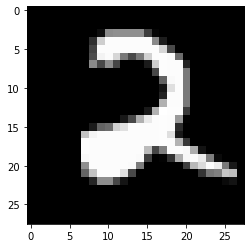

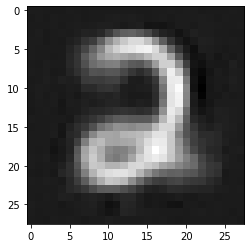

In [12]:
with torch.no_grad():
    import random

    index = int(random.random() * x_test.size(0))

    recon = model(x_test[index].view(1, -1)).squeeze()

    show_image(x_test[index])
    show_image(recon)

## Latent Space

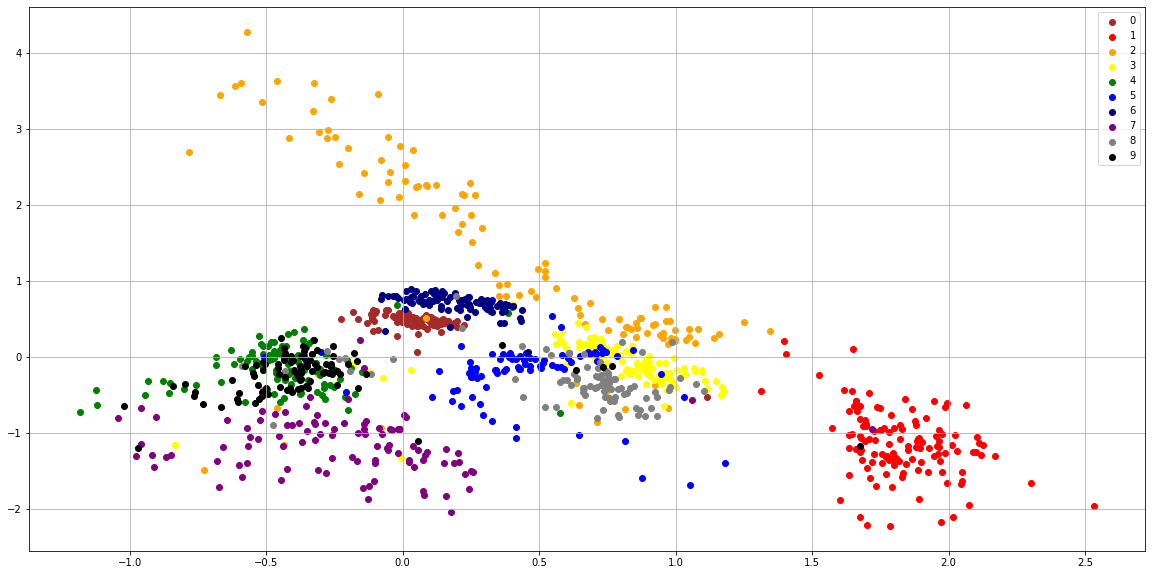

In [13]:
if config.btl_size == 2:
    color_map = [
        'brown', 'red', 'orange', 'yellow', 'green',
        'blue', 'navy', 'purple', 'gray', 'black',
    ]

    plt.figure(figsize=(20, 10))
    with torch.no_grad():
        latents = model.encoder(x_test[:1000])

        for i in range(10):
            target_latents = latents[y_test[:1000] == i]
            target_y = y_test[:1000][y_test[:1000] == i]
            plt.scatter(target_latents[:, 0],
                        target_latents[:, 1],
                        marker='o',
                        color=color_map[i],
                        label=i)

        plt.legend()
        plt.grid(axis='both')
        plt.show()

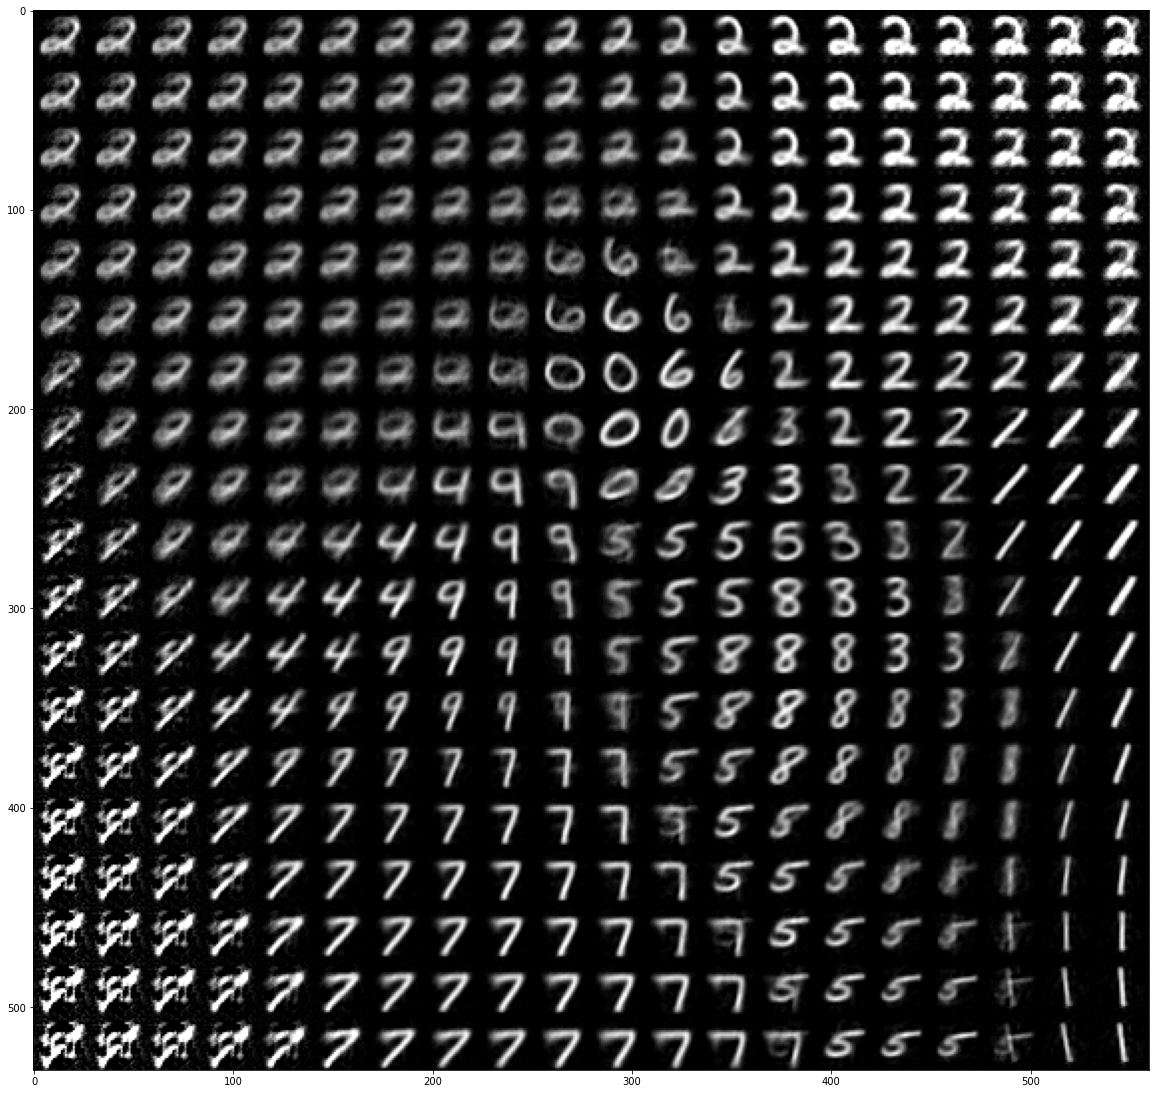

In [14]:
if config.btl_size == 2:
    min_range, max_range = -2., 2.
    n = 20
    step = (max_range - min_range) / float(n)

    with torch.no_grad():
        lines = []

        for v1 in np.arange(min_range, max_range, step):
            z = torch.stack([
                torch.FloatTensor([v1] * n),
                torch.FloatTensor([v2 for v2 in np.arange(min_range,
                                                          max_range, step)]),
            ], dim=-1)

            line = torch.clamp(model.decoder(z).view(n, 28, 28), 0, 1)
            line = torch.cat([line[i] for i in range(n-1, 0, -1)], dim=0)
            lines += [line]

        lines = torch.cat(lines, dim=-1)
        plt.figure(figsize=(20, 20))
        show_image(lines)